# Absorbing Random Walk Centrality
## A short introduction by example

The  **absorbing-centrality** module contains an implementation for a *greedy algorithm* to compute the k-central nodes in a graph according to the Absorbing Random-Walk (ARW) centrality measure. The measure and the greedy algorithm are discussed in our [paper](http://arxiv.org/abs/1509.02533) that appeared in [ICDM 2015](http://icdm2015.stonybrook.edu). Here we provide a short description of the measure and the associated problem, taken from its abstract.

"Given a graph $G = (V,E)$ and a set of query nodes $Q\subseteq V$, we aim
to identify the $k$ most central nodes in $G$ with respect to $Q$.
Specifically, we consider central nodes to be absorbing for
random walks that start at the query nodes $Q$. The goal is to 
find the set of $k$ central nodes that minimizes the expected 
length of a random walk until absorption."
    
This Python 3 notebook demonstrates usage of the greedy algorithm with a simple example.

**Note**: Run the **Setup** cells at the bottom of the notebook before other code cells.

## Dataset

For this example, we'll be using [Zachary's Karate Club](http://networkx.readthedocs.org/en/networkx-1.10/reference/generated/networkx.generators.social.karate_club_graph.html#networkx.generators.social.karate_club_graph) as our dataset.
Let's load and draw its graph.

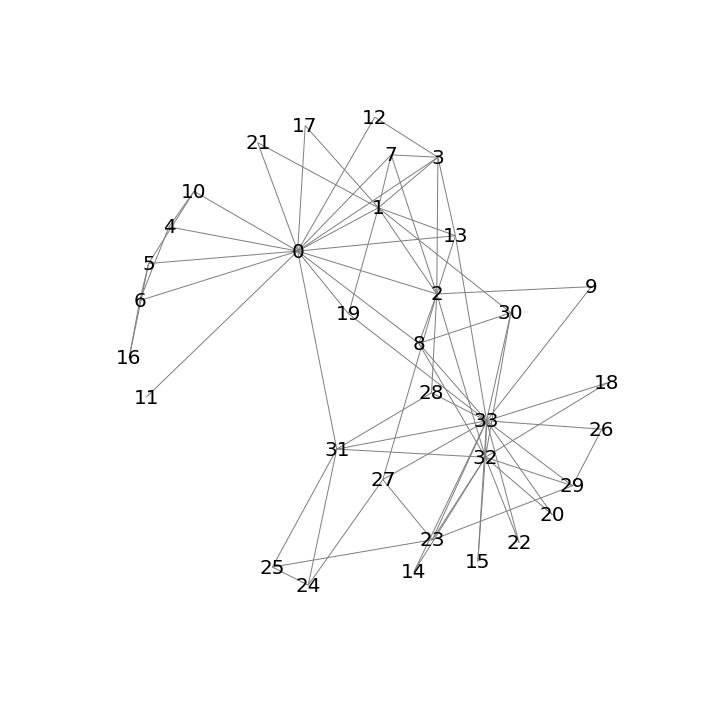

In [5]:
graph = nx.karate_club_graph() # load the graph
node_positions = nx.spring_layout(graph) # fix the node positions
make_graph_plot(graph, node_positions, node_size = 0,
                    node_color = "white", with_labels = True)

## Absorbing Random-Walk (ARW) Centrality

Now let's find the most central nodes according to ARW centrality. The problem takes the following parameters as input:

* Query nodes **Q**: random walks in our model start from nodes in *Q*. In our examples here, we also assume that a random walk might start from each node in *Q* with equal probability.
* Candidate nodes **D**: the set of nodes from which we select central nodes.
* Restart parameter **α**: at each step, a random walk *'restarts'* - i.e. moves to one of the query nodes in the next step - with probability *(1-α)*, otherwise continues to an adjacent node.
* The number of central nodes **k**: the number of *candidate* nodes that we wish to identify as central.

For our example, we have the following configuration:

In [6]:
Q = {5, 12, 14, 15, 26} # a small number of query nodes
D = graph.nodes() # all nodes are candidate nodes
alpha = 0.85 # the random walk restarts with
             # probability 1 - α = 0.15 in each step
k = 3 # number of central nodes

We employ a **greedy** algorithm, implemented as **`absorbing_centrality.algorithms.greedy_team`**, to select the `k = 3` most central nodes. The algorithm performs *k* steps, and at each step select one additional node that improves ARW centrality the most.

In [7]:
result = arw.algorithms.greedy_team(graph, k, query = Q, candidates = D,
                           with_restarts = True, alpha = alpha)

The algorithm returns a tuple with the following two elements:
* A list of **centrality scores**, one for each step of the algorithm.
* A list of **node-sets**, one for each step of the algorithm.

In [8]:
centrality_scores, node_sets = result

The *i*-th element of `centrality_scores` is the centrality score obtained for the *i*-th set of central nodes built by *greedy*. Moreover, the *i*-th node-set is always a subset of the *(i+1)*-th node-set.

In [9]:
print("Greedy returned {0} centrality scores and {1} node-sets for k = {2}."\
      .format(len(centrality_scores), len(node_sets), k))
for i in range(k):
    print("Centrality score {0:.2f} for nodes {1}."
          .format(centrality_scores[i][0], node_sets[i]))

Greedy returned 3 centrality scores and 3 node-sets for k = 3.
Centrality score 6.09 for nodes [33].
Centrality score 2.91 for nodes [33, 0].
Centrality score 1.95 for nodes [33, 0, 32].


Notice that *ARW centrality **decreases** as more nodes are selected by greedy*. That behavior is expected because, with more nodes acting as **absorbing**, random walks are more likely to be absorbed earlier, i.e. have decreased absorption time -- thus leading to decreased ARW centrality, by definition.

The $k$ nodes selected by *greedy* are returned as the last node-set and are associated with the last returned centrality score.

In [10]:
central_nodes = node_sets[k-1]
solution_centrality = centrality_scores[k-1][0]

In [11]:
print("Greedy selected nodes {0} as central, with centrality score {1:.2f}."\
      .format(central_nodes, solution_centrality))

Greedy selected nodes [33, 0, 32] as central, with centrality score 1.95.


The plot below shows query nodes **Q** in **red** color and **central nodes** returned by *greedy* in **blue**.

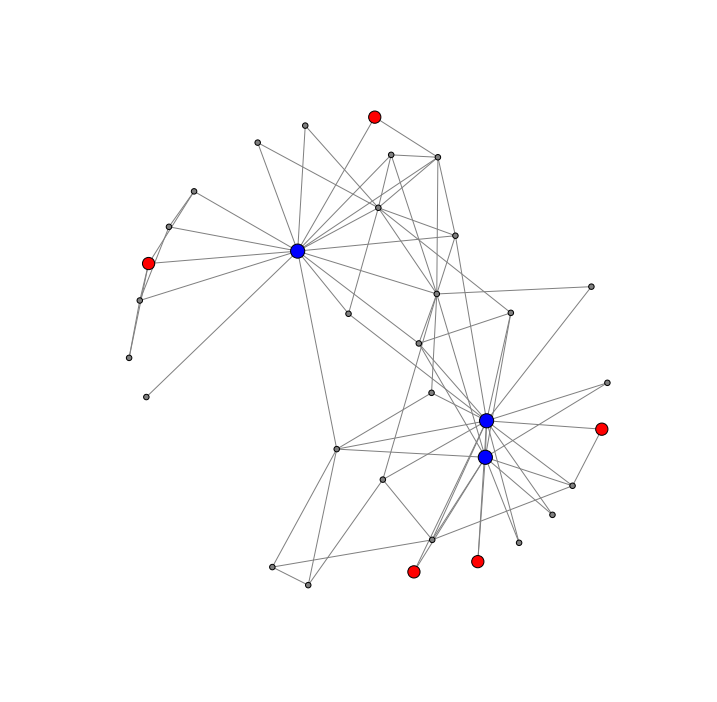

In [12]:
query_node_params = NodeParams(Q, "red", 150)
central_node_params = NodeParams(central_nodes, "blue", 200)
node_color, node_size = set_node_color_and_size(graph,
                            query_node_params, central_node_params)
make_graph_plot(graph, node_positions, node_size, node_color, with_labels = False)

### Is *greedy* optimal?

The greedy algorithm discussed above is easy to implement but generally does **not** return optimal solutions to the ARW problem. This is most easily demonstrated for the case where
* all query nodes are also candidate nodes, i.e., $Q \subseteq D$, and
* we seek the *k* most central nodes, with $k = |Q| > 1$. 

In that case, the set of **query nodes** is an **optimal** solution with centrality equal to **zero (0)**; how close does *greedy* come to that?

Let us consider the same setting as in the previous example, but this time ask *greedy* for the most central *k = 5* nodes.

In [13]:
k = 5

All other parameters of the problem remain the same and we invoke *greedy* as before.

In [14]:
greedy_result = arw.algorithms.greedy_team(graph, k, query = Q, candidates = D,
                                       with_restarts = True, alpha = alpha)
greedy_centrality_scores, greedy_node_sets = greedy_result
greedy_central_nodes = greedy_node_sets[k-1] # the k central nodes found by greedy...
greedy_centrality = greedy_centrality_scores[k-1][0] # ... and their centrality

print("Greedy returned nodes {0} as central, with centrality score {1:.2f}."\
      .format(greedy_central_nodes, greedy_centrality))

Greedy returned nodes [33, 0, 32, 5, 12] as central, with centrality score 0.72.


Let us plot *greedy*'s solution. The plot below shows in **blue** those nodes returned as **central** by *greedy* and in **red** the **query nodes** that were **not** selected as central.

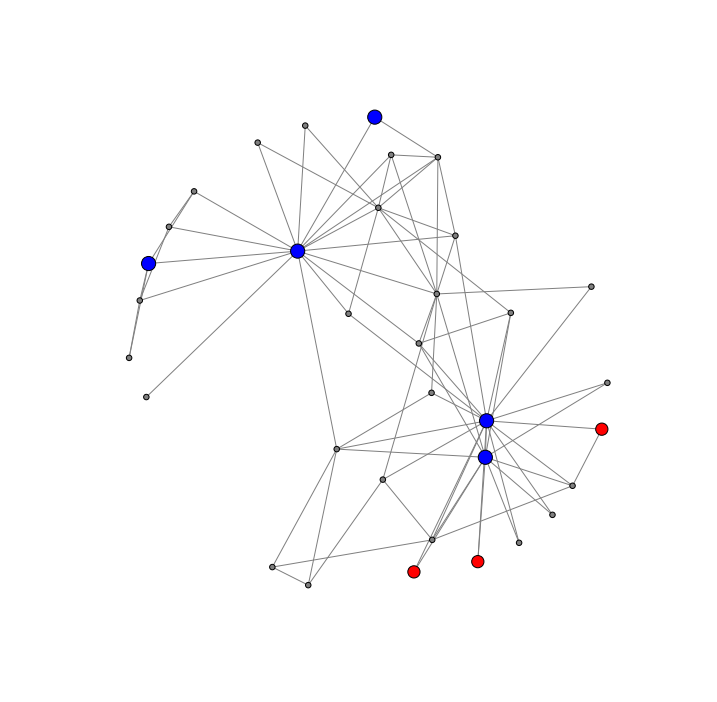

In [15]:
query_node_params = NodeParams(Q, "red", 150)
central_node_params = NodeParams(greedy_central_nodes, "blue", 200)
node_color, node_size = set_node_color_and_size(graph,
                            query_node_params, central_node_params)
make_graph_plot(graph, node_positions, node_size, node_color, with_labels = False)

We notice that the $k = 5$ nodes selected by *greedy* are not the same as the set of $k = 5$ query nodes. It is easy to see that the set of $k = 5$ query nodes would be the optimal solution in this case, with centrality **zero (0)**, as all random walks starting from them would be absorbed immediately.

In [16]:
optimal_centrality = arw.absorbing_centrality(graph, Q, query=Q,
                                              with_restarts=True, alpha=0.85)

print("Optimal centrality {0:.2f} achieved for query nodes {1}."\
      .format(optimal_centrality, Q))
print("Greedy centrality {0:.2f} achieved for nodes {1}."\
      .format(greedy_centrality, set(greedy_central_nodes)))

Optimal centrality 0.00 achieved for query nodes {26, 12, 5, 14, 15}.
Greedy centrality 0.72 achieved for nodes {0, 33, 32, 12, 5}.


## How good is *greedy*?

*Greedy* misses the optimal solution, but it does not perform arbitrarily badly.
Firstly, it is easy to see that *greedy* **does find** the optimal solution for $k = 1$.
Moreover, we have the following guarantee for $k > 1$:

*Let $m$ be the optimal ARW centrality for $k = 1$.
Moreover, let $c_{greedy}$ be the
centrality of the solution returned by *greedy* for a
given $k > 1$ and $c_{opt}$ the optimal centrality for
the same $k > 1$. Then, we have
$$(m - c_{greedy}) \geq (1 - \frac{1}{e}) (m - c_{opt}).$$
*

In [17]:
m = greedy_centrality_scores[0][0]
c_greedy = greedy_centrality_scores[k - 1][0] # for k = 5
c_opt = optimal_centrality # for k = 5

To demonstrate visually what the aforementioned guarantee means, let us consider the plot below. The plot shows with blue dots the ARW centrality of the node-sets built by *greedy* along its $k$ steps. In addition, the plot shows with grey horizontal lines the levels of $m$, $c_{greedy}$, and $c_{opt}$.

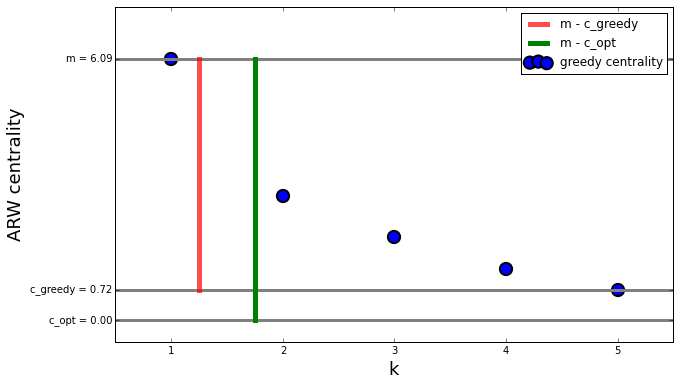

In [18]:
make_approximation_plot(m, c_greedy, c_opt, greedy_centrality_scores)

The length of the **red** segment in the plot is equal to $(m - c_{greedy})$. Intuitively, it the **improvement** in ARW centrality achieved by *greedy* as it builds node-sets of size $1$ to $k$.

Similarly, the length of the **green** segment is equal to $(m - c_{opt})$. Intuitively, it is the **improvement** in the *optimal* ARW centrality between node-sets of size $1$ to $k$.

The aforementioned guarantee means that the length of the **red** segment (improvement by *greedy*) will be at at least $(1 - \frac{1}{e}) \approx 0.63$ times the length of the **green** segment (optimal improvement). We can confirm numerically that it holds for this example.

In [19]:
question = lambda x, y: "Yes" if x >= (1 - 1/np.e) * y else "No"
answer = question(m - c_greedy, m - c_opt)
print("Does the inequality hold? -{0}".format(answer))

Does the inequality hold? -Yes


***

## Setup

Run these cells before other code cells.

In [1]:
import sys
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import collections

In [2]:
import absorbing_centrality as arw

In [3]:
%matplotlib inline

In [4]:
NodeParams = collections.namedtuple("NodeParams", ['nodes', 'color', 'size'])

def set_node_color_and_size(graph, query_node_params, 
                            candidate_node_params,
                            default_color = "grey", 
                            default_node_size = 30):
    """
    Return a list of colors for the graph nodes.
    """

    inverse_node_index = dict([(node, pos) for pos, node in enumerate(graph.nodes())])
    
    # initialize all nodes with default color
    node_color = len(graph) * [default_color]
    node_size = len(graph) * [default_node_size]
    
    for node_set_params in [query_node_params, candidate_node_params]:
        if node_set_params:
            for node in node_set_params.nodes:
                pos = inverse_node_index[node]
                node_color[pos] = node_set_params.color
                node_size[pos] = node_set_params.size
        
    return node_color, node_size

def make_graph_plot(graph, node_positions, node_size,
                                node_color, with_labels):
    """
    Plot a networkx graph with custom node positions,
    sizes, color, and the option to have labels or not.
    """
    fig, ax = plt.subplots(1, 1, figsize = (12, 12))
    ax.axis('off')
    nx.draw(graph, ax = ax, with_labels = with_labels, font_size = 20,
            node_size = node_size, node_color = node_color,
            edge_color = "grey", pos = node_positions)
    
def make_approximation_plot(m, c_greedy, c_opt, greedy_centrality_scores):
    """
    Make a plot to demonstrate the approximation guarantee
    for the greedy algorithm.
    """
    
    fig, ax = plt.subplots(1, 1, figsize = (10, 6))

    x = range(1, 1+k)
    y = [s[0] for s in greedy_centrality_scores]
    ax.set(xlim = (0.5, k+0.5), ylim = (-0.5, max(y) * 1.2))
    ax.set_xlabel("k", fontsize = 18)
    ax.set_ylabel("ARW centrality", fontsize = 18)
    ax.set(yticks = [m, c_greedy, c_opt],
           yticklabels = ["m = {0:.2f}".format(m),
                          "c_greedy = {0:.2f}".format(c_greedy),
                          "c_opt = {0:.2f}".format(c_opt)])

    _tmp = ax.plot((0, k+1), (y[0], y[0]), color = "grey", lw = 3)
    _tmp = ax.plot((0, k+1), (y[-1], y[-1]), color = "grey", lw = 3)
    _tmp = ax.plot((0, k+1), (0, 0), color = "grey", lw = 3)

    _tmp = ax.plot((1.25, 1.25), (y[0], y[-1]), lw = 5, color = "red",
                   alpha = 0.7, label = "m - c_greedy")
    _tmp = ax.plot((1.75, 1.75), (y[0], 0), lw = 5, color = "green", label = "m - c_opt")

    _tmp = ax.scatter(x, y, s = 150, lw =2, label = "greedy centrality")

    _tmp = ax.legend(loc = 1)